### Airbnb Classification

**Airbnb Business Model**

**Marketplace** that connect people who offers home with peope who wants to rent a home. 

Offert:
* Portfolio Density/Diversity
* Portfolio Size
* Average Price

Demand:
* LTV
* CAC
* Number of Users



**Business Problem**

New users on Airbnb can book a place to stay in 34,000+ cities across 190+ countries. By accurately predicting where a new user will book their first travel experience, Airbnb can share more personalized content with their community, decrease the average time to first booking, and better forecast demand.

**Data Description**

In this challenge, you are given a list of users along with their demographics, web session records, and some summary statistics. You are asked to predict which country a new user's first booking destination will be. All the users in this dataset are from the USA.

There are 12 possible outcomes of the destination country: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other'. Please note that 'NDF' is different from 'other' because 'other' means there was a booking, but is to a country not included in the list, while 'NDF' means there wasn't a booking.

The training and test sets are split by dates. In the test set, you will predict all the new users with first activities after 7/1/2014 (note: this is updated on 12/5/15 when the competition restarted). In the sessions dataset, the data only dates back to 1/1/2014, while the users dataset dates back to 2010. 




**Solution**
1. Predict and load in a database, use data visualization to see results

2. API: 
    * Input: id and customer features
    * Output: id + predict + probability

# 0.0. Load


## 0.1. Imports


In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import os

from scipy import stats as ss
from sklearn import model_selection as ms
from sklearn import preprocessing as pp
from sklearn import metrics 

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

from keras import models as ml
from keras import layers as l

from scikitplot import metrics as mt

import random


## 0.2. Helper Functions

In [2]:
def num_stats(df):
    num_attributes = df.select_dtypes(['int64', 'float64'])

    #central tendency
    mean = pd.DataFrame(num_attributes.apply(np.mean)).T
    median = pd.DataFrame(num_attributes.apply(np.mean)).T

    #dispersion
    min_ = pd.DataFrame(num_attributes.apply(min)).T
    max_ = pd.DataFrame(num_attributes.apply(max)).T
    range_ = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    skew  = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    std = pd.DataFrame(num_attributes.apply(np.std)).T

    m_numeric = pd.concat([min_, max_, range_, mean, median, std, skew, kurtosis]).T.reset_index()

    m_numeric.columns = ['attributes','min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    return m_numeric

def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / min(kcorr-1, rcorr-1))

## 0.3. Load Dataset

In [3]:
df_raw = pd.read_csv('../data/train_users_2.csv', low_memory=True)
df_sessions = pd.read_csv('../data/sessions.csv')

# 1.0. Data Description

In [5]:
df1 = df_raw.copy()

## 1.1. Data Dimensions

In [5]:
print('Train dataset:')
print('Rows:{}'.format(df_raw.shape[0]))
print('Cols:{}'.format(df_raw.shape[1]))

print('\nSessions dataset:')
print('Rows:{}'.format(df_sessions.shape[0]))
print('Cols:{}'.format(df_sessions.shape[1]))

Train dataset:
Rows:213451
Cols:16

Sessions dataset:
Rows:10567737
Cols:6


## 1.2. Data Types

In [6]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [8]:
df_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

In [9]:
df1.sample().T

,86116
id,28yvbq09z9
date_account_created,2013-06-24
timestamp_first_active,20130624142943
date_first_booking,NaN
gender,MALE
age,33.0
signup_method,facebook
signup_flow,0
language,en
affiliate_channel,sem-brand


In [10]:
df_sessions.sample().T

,8299176
user_id,mpelusc7d5
action,ajax_lwlb_contact
action_type,click
action_detail,contact_host
device_type,Windows Desktop
secs_elapsed,62353.0


## 1.2. NA Check

In [11]:
df1.isna().sum()/len(df1)


id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [12]:
df_sessions.isna().sum()/len(df_sessions)

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

## 1.3 Fill NA

In [6]:
#==================Training================
#date_first_booking
date_first_booking_max = pd.to_datetime(df1['date_first_booking']).max().strftime('%Y-%m-%d')
df1['date_first_booking']=df1['date_first_booking'].fillna(date_first_booking_max)

#age
age_mean = df1['age'].mean()
df1['age'] = df1['age'].fillna(age_mean)

# first_affiliate_tracked
df1['first_affiliate_tracked'] = df1['first_affiliate_tracked'].dropna()

#==================Sessions==============
df_sessions = df_sessions.dropna()


## 1.4. Change Data Type

In [7]:
#date_account_created
df1['date_account_created'] = pd.to_datetime(df1['date_account_created'])

#timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format='%Y%m%d%H%M%S')
# date_first_booking
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'])
#age
df1['age'] = df1['age'].astype('int64')



## 1.5. Check Target Distribution

In [9]:
df1['country_destination'].value_counts(normalize=True)

NDF      0.583473
US       0.292226
other    0.047290
FR       0.023532
IT       0.013282
GB       0.010888
ES       0.010536
CA       0.006690
DE       0.004971
NL       0.003570
AU       0.002525
PT       0.001017
Name: country_destination, dtype: float64

## 1.6. Descriptive Statistics


### 1.6.1. Numerical Users

In [10]:
num_stats(df1)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,1.0,2014.0,2013.0,49.392830,49.392830,119.344021,16.210083,263.517271
1,signup_flow,0.0,25.0,25.0,3.267387,3.267387,7.637689,2.234366,3.324444


### 1.6.2. Categorical Users

In [11]:
cat_attributes = df1.select_dtypes('object')
cat_attributes.drop('id', axis=1).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,213451,213451,213451,213451,213451,207386,213451,213451,213451,213451
unique,4,3,25,8,18,7,4,9,52,12
top,-unknown-,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,95688,152897,206314,137727,137426,109232,182717,89600,63845,124543


### 1.6.3. Numerical sessions

In [18]:
num_stats(df_sessions)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,secs_elapsed,0.0,1799977.0,1799977.0,19961.8251,19961.8251,88849.388449,11.137761,154.84312


### 1.6.4. Categorical Sessions

In [19]:
cat_attributes_session = df_sessions.select_dtypes('object').drop('user_id', axis=1)
cat_attributes_session.describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


In [20]:
#List os cat attributes for cramer v correlation
cat_attributes_list = cat_attributes_session.columns.tolist()

#dict to get all corr (rowxcolumn)
corr_dict = {}
for i in range(len(cat_attributes_list)):
    corr_list=[]
    for j in range(len(cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        corr = cramer_v(cat_attributes_session[ref], cat_attributes_session[feat])
        corr_list.append(corr)
    corr_dict[ref] = corr_list

KeyboardInterrupt: 

In [ ]:
corr_df = pd.DataFrame(corr_dict)
corr_df = corr_df.set_index(corr_df.columns)


In [ ]:
sns.heatmap(corr_df, annot=True);


Conclusion: High correlation between:
* action and action_type
* action and action_detail

# 2.0. Feature Engineering

In [9]:
df2 = df1.copy()

In [10]:
#time between first booking and first active
df2['first_active'] = pd.to_datetime(df2['timestamp_first_active'].dt.strftime('%Y-%m-%d'))
df2['days_from_active_to_booking'] = (df2['date_first_booking'] - df2['first_active']).dt.days

#time between first booking and account created
df2['days_from_account_created_to_booking'] = (df2['date_first_booking'] - df2['date_account_created']).dt.days

#time between account created and first active
df2['days_from_active_to_account_created'] = (df2['date_account_created'] - df2['first_active']).dt.days

#year  of first active
df2['year_first_active'] = df2['first_active'].dt.year

#month of first active
df2['month_first_active'] = df2['first_active'].dt.month

#day of first active
df2['day_first_active'] = df2['first_active'].dt.day

#day of week of first active
df2['day_of_week_first_active'] = df2['first_active'].dt.dayofweek

#week of year of first active
df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear


#year  of first booking
df2['year_first_booking'] = df2['date_first_booking'].dt.year

#month of first booking
df2['month_first_booking'] = df2['date_first_booking'].dt.month

#day of first booking
df2['day_first_booking'] = df2['date_first_booking'].dt.day

#day of week of first booking
df2['day_of_week_first_booking'] = df2['date_first_booking'].dt.dayofweek

#week of year of first booking
df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear


#year  of account created
df2['year_account_created'] = df2['date_account_created'].dt.year

#month of account created
df2['month_account_created'] = df2['date_account_created'].dt.month

#day of account created
df2['day_account_created'] = df2['date_account_created'].dt.day

#day of week of account created
df2['day_of_week_account_created'] = df2['date_account_created'].dt.dayofweek

#week of year of account created
df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear

C:\Users\HeitorFelixdeOliveir\AppData\Local\Temp\ipykernel_16776\3870884473.py:24: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear
C:\Users\HeitorFelixdeOliveir\AppData\Local\Temp\ipykernel_16776\3870884473.py:40: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear
C:\Users\HeitorFelixdeOliveir\AppData\Local\Temp\ipykernel_16776\3870884473.py:56: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear


In [14]:
df2.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,year_first_booking,month_first_booking,day_first_booking,day_of_week_first_booking,week_of_year_first_booking,year_account_created,month_account_created,day_account_created,day_of_week_account_created,week_of_year_account_created
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,2015-06-29,-unknown-,49,facebook,0,en,direct,...,2015,6,29,0,27,2010,6,28,0,26
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,2015-06-29,MALE,38,facebook,0,en,seo,...,2015,6,29,0,27,2011,5,25,2,21
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,...,2010,8,2,0,31,2010,9,28,1,39
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42,facebook,0,en,direct,...,2012,9,8,5,36,2011,12,5,0,49
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41,basic,0,en,direct,...,2010,2,18,3,7,2010,9,14,1,37


### 2.1. Sessions

In [15]:
df2.shape[0]

213451

In [16]:
df_sessions['action'].value_counts().head(15)

show                     2178382
index                     824289
search_results            723113
personalize               704745
search                    533812
ajax_refresh_subtotal     486410
similar_listings          363420
update                    362461
social_connections        337754
reviews                   319306
active                    176259
dashboard                 152382
header_userpic            140829
collections               124059
edit                      108919
Name: action, dtype: int64

In [11]:
# n_clicks
n_clicks = df_sessions[df_sessions['action_type']=='click'].groupby('user_id').agg(n_clicks = ('user_id', 'count')).reset_index()
df2 = pd.merge(df2, n_clicks.rename(columns = {'user_id' : 'id'}), on ='id', how='left')
df2['n_clicks'].fillna(0, inplace=True)

n_reviews = df_sessions[df_sessions['action']=='reviews'].groupby('user_id').agg(n_reviews = ('user_id', 'count')).reset_index()
df2 = pd.merge(df2, n_reviews.rename(columns = {'user_id' : 'id'}), on ='id', how='left')
df2['n_reviews'].fillna(0, inplace=True)

# 3.0. Data Filtering

In [12]:
df3= df2.copy()

## 3.1. Filtering Rows

In [19]:
df3.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,day_first_booking,day_of_week_first_booking,week_of_year_first_booking,year_account_created,month_account_created,day_account_created,day_of_week_account_created,week_of_year_account_created,n_clicks,n_reviews
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,2015-06-29,-unknown-,49,facebook,0,en,direct,...,29,0,27,2010,6,28,0,26,0.0,0.0
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,2015-06-29,MALE,38,facebook,0,en,seo,...,29,0,27,2011,5,25,2,21,0.0,0.0
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,...,2,0,31,2010,9,28,1,39,0.0,0.0
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42,facebook,0,en,direct,...,8,5,36,2011,12,5,0,49,0.0,0.0
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41,basic,0,en,direct,...,18,3,7,2010,9,14,1,37,0.0,0.0


In [13]:
#age greater thaan 15 and lower than 100 - few people
print(len(df3), 'before filter')
df3 = df3[(df3['age']>15) & (df3['age']<100)]
print(len(df3), 'after filter')

213451 before filter
211015 after filter


## 3.2. Columns Selections

# 4.0. Data Preparation

In [14]:
df4 = df3.copy()

### 4.1. Encoding

In [15]:
#dummy variable - signup_method
dummy = pd.get_dummies(df4['signup_method'])
df4 = pd.concat([df4, dummy], axis=1)

# language to binary, either is english or not
df4['language_en'] = np.where(df4['language']=='en', 1, 0)

# signup to binary, either is web or not
df4['signup_on_web'] = np.where(df4['signup_app']== 'Web', 1, 0)

# first_affiliate_tracked to binary, either is tracked or not
df4['tracked'] = np.where(df4['first_affiliate_tracked']=='untracked', 0, 1)

#binary features from first_device_type
df4['first_device_apple'] = np.where(df4['first_device_type'].isin(['Mac Desktop', 'iPhone', 'iPad']), 1 ,0)
df4['first_device_desktop'] = np.where(df4['first_device_type'].isin(['Mac Desktop', 'Desktop', 'Windows Desktop']), 1, 0)

# frequency encoding
affiliate_channel_frequency_encoding = df4['affiliate_channel'].value_counts(normalize=True)
df4['affiliate_channel'] = df4['affiliate_channel'].map(affiliate_channel_frequency_encoding)

affiliate_provider_frequency_encoding = df4['affiliate_provider'].value_counts(normalize=True)
df4['affiliate_provider'] = df4['affiliate_provider'].map(affiliate_provider_frequency_encoding)

first_browser_frequency_encoding = df4['first_browser'].value_counts(normalize=True)
df4['first_browser'] = df4['first_browser'].map(first_browser_frequency_encoding)

### 4.2. Rescaling

In [16]:
from sklearn.preprocessing import MinMaxScaler

# Selecionar as colunas a serem redimensionadas
columns_to_rescale = [
"age",
"signup_flow",
"n_reviews",
"n_clicks"
]

# Criar uma instância do MinMaxScaler
scaler = MinMaxScaler()

# Redimensionar as colunas selecionadas
df4[columns_to_rescale] = scaler.fit_transform(df4[columns_to_rescale])


In [17]:
# temporal columns 
temporal_columns = ["days_from_active_to_booking",
"days_from_account_created_to_booking",
"days_from_active_to_account_created",
"year_first_active",
"month_first_active",
"day_first_active",
"day_of_week_first_active",
"week_of_year_first_active",
"year_first_booking",
"month_first_booking",
"day_first_booking",
"day_of_week_first_booking",
"week_of_year_first_booking",
"year_account_created",
"month_account_created",
"day_account_created",
"day_of_week_account_created",
"week_of_year_account_created"]

 # month_account_created
df4['month_account_created_sin'] = df4['month_account_created'].apply( lambda x: np.sin( x * (2*np.pi/12 ) ) )
df4['month_account_created_cos'] = df4['month_account_created'].apply( lambda x: np.cos( x * (2*np.pi/12 ) ) )

# week_account_created
df4['week_account_created_sin'] = df4['week_of_year_account_created'].apply( lambda x: np.sin( x * (2*np.pi/52 ) ) )
df4['week_account_created_cos'] = df4['week_of_year_account_created'].apply( lambda x: np.cos( x * (2*np.pi/52 ) ) )

# day_account_created
df4['day_account_created_sin'] = df4['day_account_created'].apply( lambda x: np.sin( x * (2*np.pi/30 ) ) )
df4['day_account_created_cos'] = df4['day_account_created'].apply( lambda x: np.cos( x * (2*np.pi/30 ) ) )

# day_of_week_account_created
df4['day_of_week_account_created_sin'] = df4['day_of_week_account_created'].apply( lambda x: np.sin( x * (2*np.pi/7 ) ) )
df4['day_of_week_account_created_cos'] = df4['day_of_week_account_created'].apply( lambda x: np.cos( x * (2*np.pi/7 ) ) )

# month_first_booking
df4['month_first_booking_sin'] = df4['month_first_booking'].apply( lambda x: np.sin( x * (2*np.pi/12 ) ) )
df4['month_first_booking_cos'] = df4['month_first_booking'].apply( lambda x: np.cos( x * (2*np.pi/12 ) ) )

# day_first_booking
df4['day_first_booking_sin'] = df4['day_first_booking'].apply( lambda x: np.sin( x * (2*np.pi/30 ) ) )
df4['day_first_booking_cos'] = df4['day_first_booking'].apply( lambda x: np.cos( x * (2*np.pi/30 ) ) )

# day_of_week_first_booking
df4['day_of_week_first_booking_sin'] = df4['day_of_week_first_booking'].apply( lambda x: np.sin( x * (2*np.pi/7 ) ) )
df4['day_of_week_first_booking_cos'] = df4['day_of_week_first_booking'].apply( lambda x: np.cos( x * (2*np.pi/7 ) ) )

In [18]:
df4.drop(temporal_columns, axis=1, inplace=True)

# 5.0. Feature Selections

In [19]:
df4.select_dtypes('object').columns

Index(['id', 'gender', 'signup_method', 'language', 'first_affiliate_tracked',
       'signup_app', 'first_device_type', 'country_destination'],
      dtype='object')

In [20]:
cols_drop = ['gender', 'gender', 'signup_method', 'language', 'first_affiliate_tracked',
       'signup_app', 'first_device_type','date_account_created', 'timestamp_first_active',
             'date_first_booking', 'first_active'] #original dates
df5 = df4.drop(cols_drop, axis=1)

In [85]:
# cols_drop = [
# "month_first_active",
# "day_first_active",
# "day_of_week_first_active",
# "week_of_year_first_active",
# "month_first_booking",
# "day_first_booking",
# "day_of_week_first_booking",
# "week_of_year_first_booking",
# "month_account_created",
# "day_account_created",
# "day_of_week_account_created",
# "week_of_year_account_created"] #original dates
# df5 = df5.drop(cols_drop, axis=1)

In [86]:
df5.head()

,id,age,signup_flow,affiliate_channel,affiliate_provider,first_browser,country_destination,n_clicks,n_reviews,basic,...,day_account_created_sin,day_account_created_cos,day_of_week_account_created_sin,day_of_week_account_created_cos,month_first_booking_sin,month_first_booking_cos,day_first_booking_sin,day_first_booking_cos,day_of_week_first_booking_sin,day_of_week_first_booking_cos
0,gxn3p5htnn,0.397590,0.00,0.645381,0.643978,0.299197,NDF,0.0,0.0,0,...,0.187381,0.982287,0.000000,1.000000,0.235759,0.971812,0.194234,0.980955,0.000000,1.000000
1,820tgsjxq7,0.265060,0.00,0.040556,0.241926,0.299197,NDF,0.0,0.0,0,...,0.166769,0.985996,0.294755,0.955573,0.235759,0.971812,0.194234,0.980955,0.000000,1.000000
2,4ft3gnwmtx,0.481928,0.12,0.645381,0.643978,0.098491,US,0.0,0.0,1,...,0.187381,0.982287,0.149042,0.988831,0.327068,0.945001,0.006981,0.999976,0.000000,1.000000
3,bjjt8pjhuk,0.313253,0.00,0.645381,0.643978,0.157505,other,0.0,0.0,0,...,0.027922,0.999610,0.000000,1.000000,0.371662,0.928368,0.048850,0.998806,0.680173,0.733052
4,87mebub9p4,0.301205,0.00,0.645381,0.643978,0.299197,US,0.0,0.0,1,...,0.090633,0.995884,0.149042,0.988831,0.047582,0.998867,0.118404,0.992966,0.433884,0.900969


In [21]:
X = df5.drop(['country_destination', 'id'], axis=1)
y = df5['country_destination'].copy()

In [22]:
X_train, X_test, y_train, y_test = ms.train_test_split(X,y,test_size=0.2, random_state=32)

# 6.0. Sampling

In [28]:
majority_value = y.value_counts()[0]

In [29]:
majority_value

123454

In [38]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

# Calcular a frequência de cada classe
class_counts = y.value_counts()


# Calcular os pesos de classe inversamente proporcionais à frequência
class_weights = {'NDF': majority_value*1,
                 'US': int(majority_value*0.5),
                 'other': int(majority_value*0.18),
                 'FR': int(majority_value*0.15) ,
                 'IT': int(majority_value*0.13),
                 'GB': int(majority_value*0.13),
                 'ES': int(majority_value*0.13),
                 'CA': int(majority_value*0.13),
                 'DE': int(majority_value*0.13),
                 'NL': int(majority_value*0.09),
                 'AU': int(majority_value*0.09),
                 'PT': int(majority_value*0.09)
                }

# Instanciar o SMOTE com os pesos de classe definidos
smote = SMOTE(sampling_strategy=class_weights)

# Aplicar o resampling usando o SMOTE
X_resampled, y_resampled = smote.fit_resample(X, y)


In [39]:
y.value_counts()

NDF      123454
US        61433
other      9929
FR         4961
IT         2786
GB         2287
ES         2219
CA         1406
DE         1044
NL          750
AU          531
PT          215
Name: country_destination, dtype: int64

In [35]:
y_resampled.value_counts()

NDF      123454
US        61727
other     30863
FR        20987
GB        18518
ES        18518
IT        18518
CA        14814
DE        14814
PT        12345
NL        12345
AU        12345
Name: country_destination, dtype: int64

## 6.0. Machine Learning Model

In [36]:
# wieghts to baseline Model
weights = df1['country_destination'].value_counts(normalize=True).sort_index().tolist()

## 5.1. Baseline Model

In [100]:
import random

country_destination_list = df4['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_test.shape[0]
yhat_random = random.choices(population=country_destination_list, k=k_num, weights=weights)

## 5.2. Neural Network - MLP

In [40]:
#split dataset into training and test
X_train, X_test, y_train, y_test = ms.train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=32)

In [39]:
X_train.head()

,age,signup_flow,affiliate_channel,affiliate_provider,first_browser,days_from_active_to_booking,days_from_account_created_to_booking,days_from_active_to_account_created,year_first_active,year_first_booking,...,n_clicks,n_reviews,basic,facebook,google,language_en,signup_on_web,tracked,first_device_apple,first_device_desktop
226360,0.133450,0.00,0.645381,0.643978,0.272140,0.003456,0.151882,0.0,0.8,0.6,...,0.000000,0.0,0,1,0,1,1,0,1,1
35108,0.397590,0.12,0.645381,0.643978,0.090382,0.000436,0.148936,0.0,0.6,0.4,...,0.000000,0.0,1,0,0,1,1,0,1,0
145462,0.108434,0.00,0.645381,0.643978,0.299197,0.000436,0.148936,0.0,1.0,0.8,...,0.002026,0.0,1,0,0,1,1,0,0,1
69654,0.144578,0.00,0.645381,0.643978,0.211246,0.352377,0.492340,0.0,0.8,1.0,...,0.000000,0.0,1,0,0,1,1,0,1,1
294839,0.291278,0.00,0.645381,0.643978,0.299197,0.000436,0.148936,0.0,0.8,0.6,...,0.000000,0.0,0,1,0,1,1,1,0,1


In [40]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1,1)).toarray()
y_test_nn = ohe.fit_transform(y_test.values.reshape(-1,1)).toarray()

In [89]:
#model definition
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

model_path = '../models/model_resampled_v3.h5'
if os.path.exists(model_path):
    model = load_model(model_path)
    
else:
    # Definindo o Early Stopping
    early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

    model = ml.Sequential()
    model.add(l.Dense(256, input_dim=X_train.shape[1] , activation='relu'))
    model.add(l.Dropout(0.2))  # Adicionando camada de dropout com taxa de 20%
    model.add(l.Dense(12, activation='softmax'))

    #model compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    #train model
    model.fit(X_train, y_train_nn, epochs=50, validation_data=(X_test, y_test_nn), callbacks=[early_stopping])

    model.save('../models/model_resampled_v3.h5')

Epoch 1/50
9784/9784 [==============================] - 22s 2ms/step - loss: 1.5472 - accuracy: 0.4690 - val_loss: 1.5005 - val_accuracy: 0.4782
Epoch 2/50
9784/9784 [==============================] - 24s 2ms/step - loss: 1.5040 - accuracy: 0.4744 - val_loss: 1.4723 - val_accuracy: 0.4818
Epoch 3/50
9784/9784 [==============================] - 20s 2ms/step - loss: 1.4811 - accuracy: 0.4787 - val_loss: 1.4533 - val_accuracy: 0.4864
Epoch 4/50
5679/9784 [================>.............] - ETA: 7s - loss: 1.4656 - accuracy: 0.4826


KeyboardInterrupt



### 5.3 Other Models

In [24]:
from lightgbm import LGBMClassifier

In [25]:
from sklearn.preprocessing import LabelEncoder

def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Converter classes categóricas para valores numéricos
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    model.fit(X_train, y_train_encoded)
    yhat_encoded = model.predict(X_test)
    
    # Converter previsões numéricas de volta para a forma original
    yhat = label_encoder.inverse_transform(yhat_encoded)
    
    # Accuracy
    acc_random = metrics.accuracy_score(y_test, yhat)
    print(f'Accuracy score: {acc_random:.3f}')
    
    # Balanced accuracy
    balanced_acc_random = metrics.balanced_accuracy_score(y_test, yhat)
    print(f'Balanced accuracy score: {balanced_acc_random:.3f}')
    
    mt.plot_confusion_matrix(y_test, yhat, normalize=False, figsize=(10, 10), labels=label_encoder.classes_);


In [71]:
y_test.unique()

array(['CA', 'NDF', 'AU', 'other', 'PT', 'FR', 'GB', 'ES', 'DE', 'US',
       'NL', 'IT'], dtype=object)

# 6.0. Performance

## 6.1. Baseline Performance

Accuracy score: 0.212
Balanced accuracy score: 0.083
Kappa score: -0.001


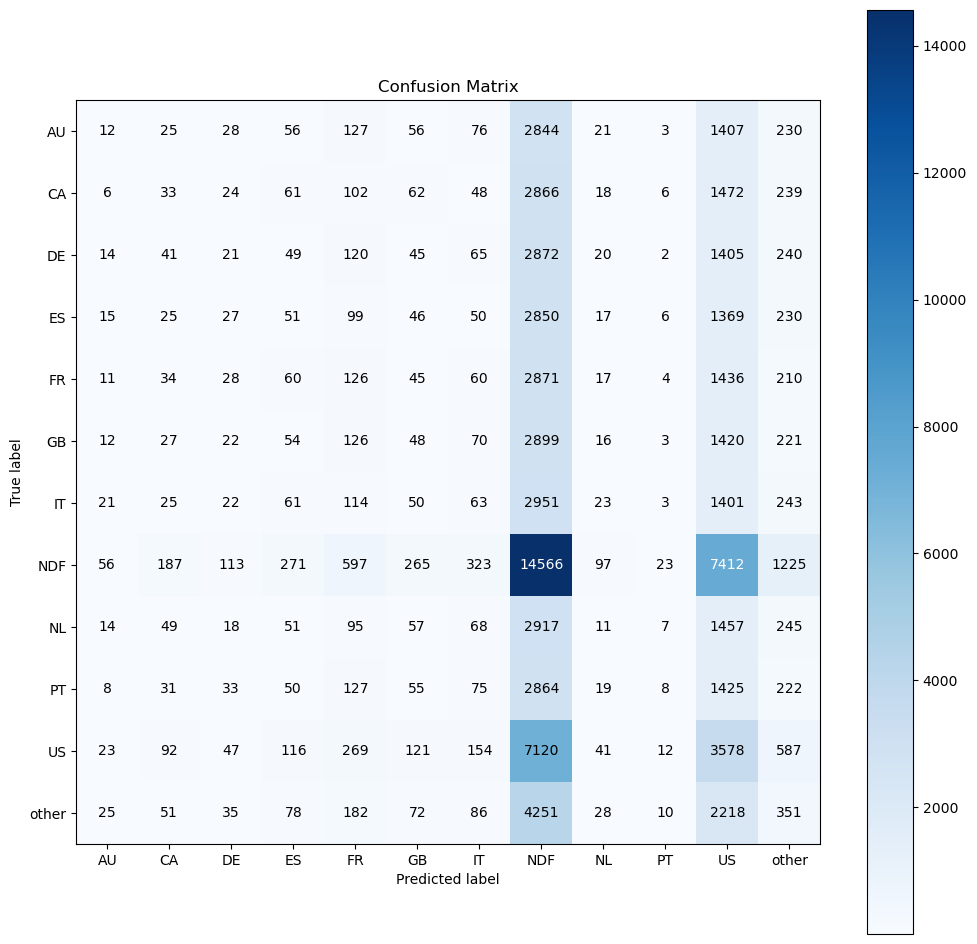

In [51]:
#Accuracy
acc_random = metrics.accuracy_score(y_test, yhat_random)
print(f'Accuracy score: {acc_random:.3f}')

#Balanced accurace
balanced_acc_random = metrics.balanced_accuracy_score(y_test, yhat_random)
print(f'Balanced accuracy score: {balanced_acc_random:.3f}')

#Kappa
kappa_random = metrics.cohen_kappa_score(y_test, yhat_random)
print(f'Kappa score: {kappa_random:.3f}')

#Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(12,12));

## 6.2. NN Performance

In [77]:
#prediction
pred_nn = model.predict(X_test)

#invert prediction
yhat_nn = ohe.inverse_transform(pred_nn)

#prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1,-1)[0]

2778/2778 [==============================] - 3s 905us/step


In [78]:
yhat_nn

array(['NDF', 'NDF', 'NDF', ..., 'NDF', 'NDF', 'DE'], dtype=object)

Accuracy score: 0.5028575928717683
Balanced accuracy score: 0.34625168780964105
Kappa score: 0.4174971065064973


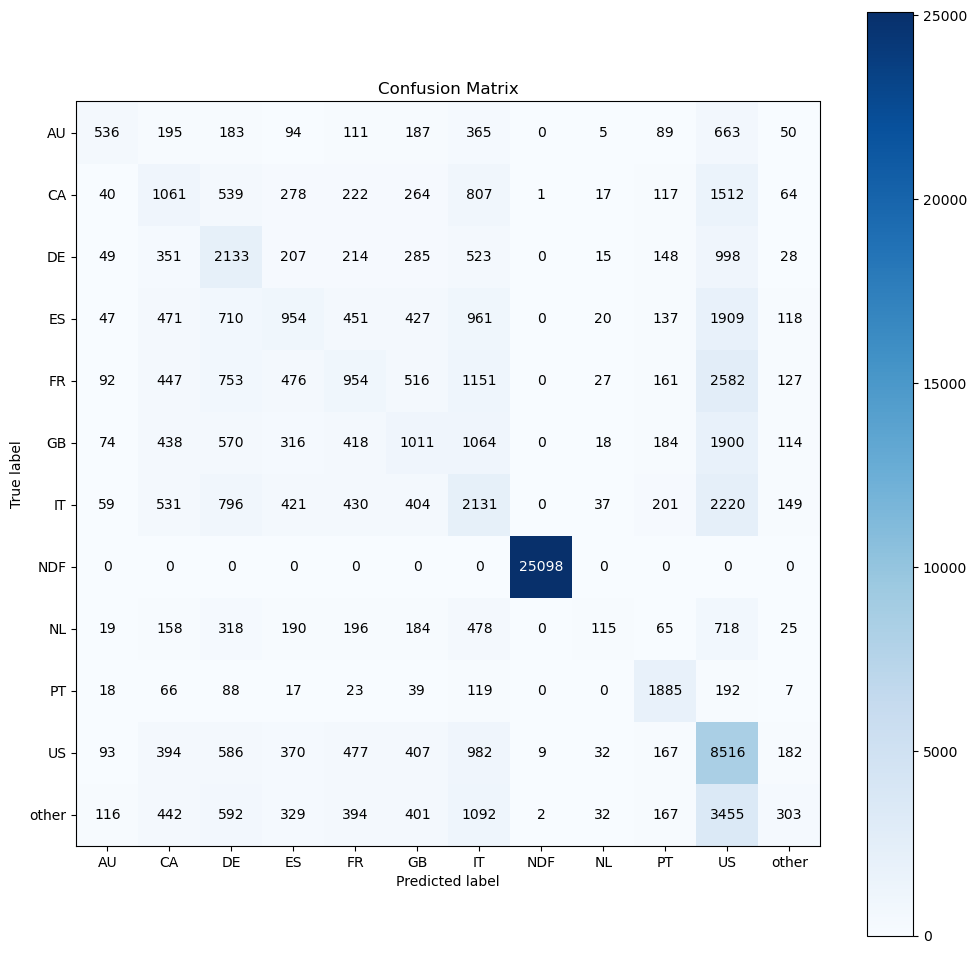

In [79]:
#Accuracy
acc_nn = metrics.accuracy_score(y_test_nn, yhat_nn)
print(f'Accuracy score: {acc_nn}')


#Balanced accurace
balanced_acc_nn = metrics.balanced_accuracy_score(y_test_nn, yhat_nn)
print(f'Balanced accuracy score: {balanced_acc_nn}')

#Kappa
kappa_nn = metrics.cohen_kappa_score(y_test_nn, yhat_nn)
print(f'Kappa score: {kappa_nn}')

#Confusion Matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(12,12));



In [55]:
pd.Series(yhat_nn).value_counts()

NDF    24720
US     17483
dtype: int64

### 6.3. LGBM

Accuracy score: 0.686
Balanced accuracy score: 0.557


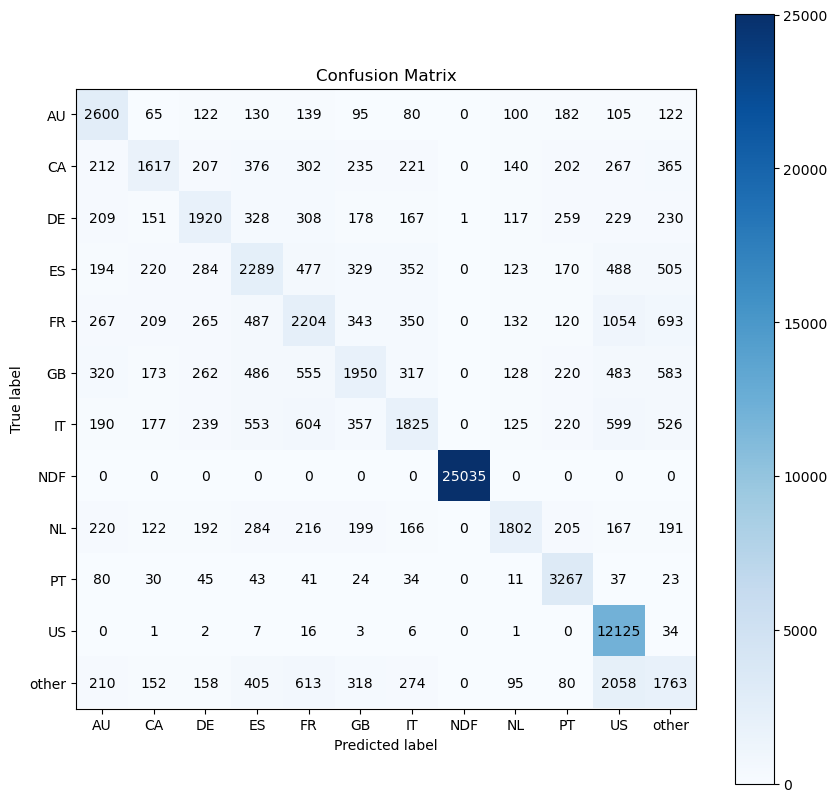

In [102]:
evaluate_model(LGBMClassifier(), X_train, X_test, y_train, y_test)

### 6.4. XGBoost

In [75]:
evaluate_model(XGBClassifier(), X_train, X_test, y_train, y_test)

KeyboardInterrupt: 

### 6.5. RandomForest

In [74]:
evaluate_model(RandomForestClassifier(), X_train, X_test, y_train, y_test)


KeyboardInterrupt



### 6.6. ExtraTrees

In [ ]:
evaluate_model(ExtraTreesClassifier(), X_train, X_test, y_train, y_test)

### 6.7. Logistic Regression

C:\Users\HeitorFelixdeOliveir\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy score: 0.436
Balanced accuracy score: 0.167


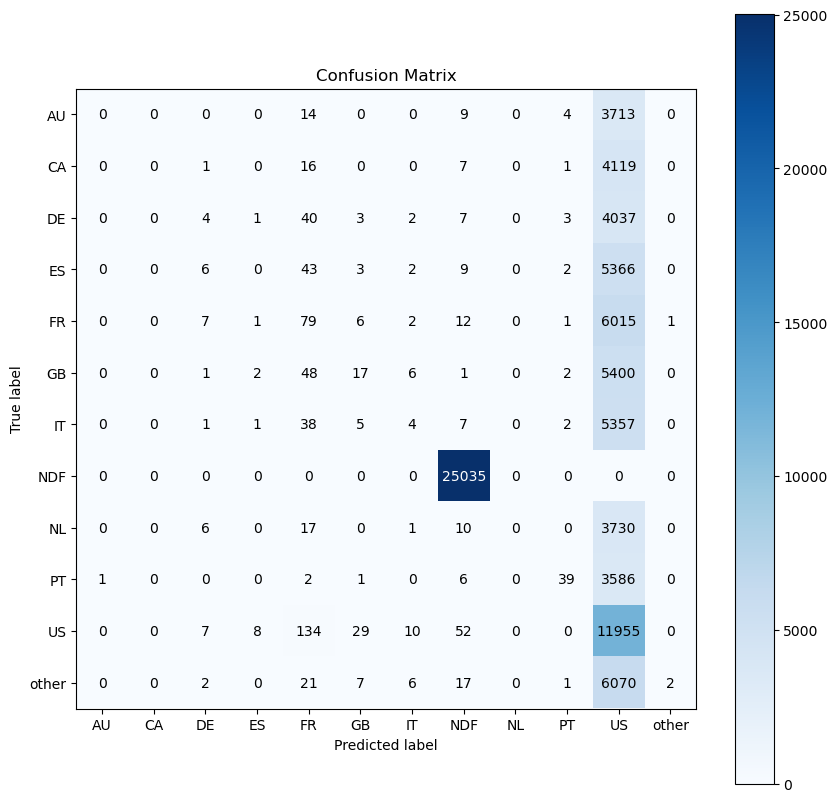

In [73]:
evaluate_model(LogisticRegression(), X_train, X_test, y_train, y_test)

### 6.8 KNN

Accuracy score: 0.764
Balanced accuracy score: 0.746


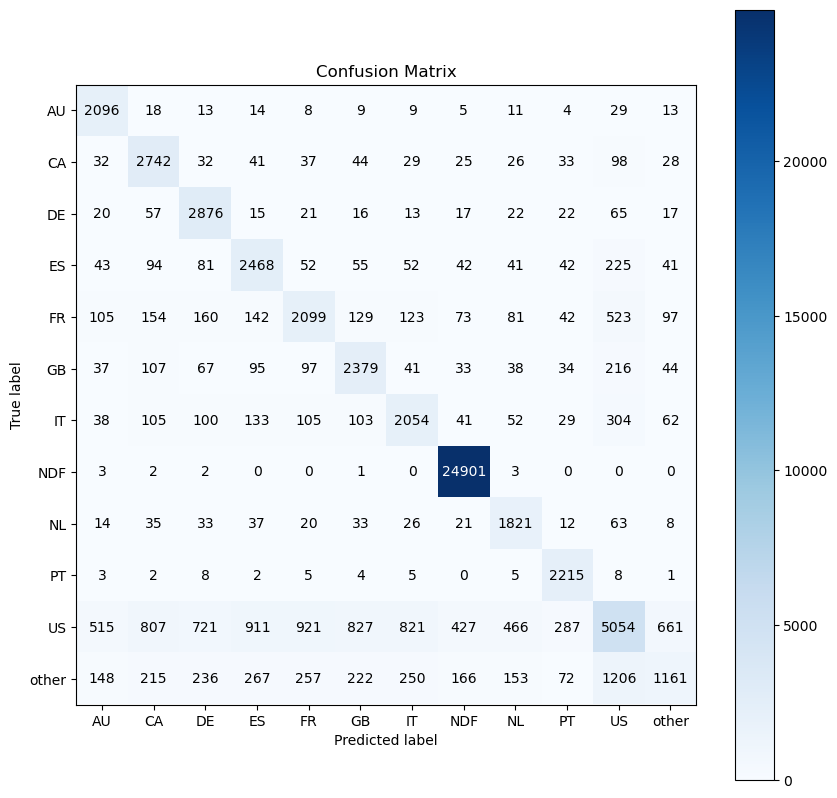

In [41]:
evaluate_model(KNeighborsClassifier(n_neighbors=10), X_train, X_test, y_train, y_test)

In [85]:
# balanced_acc_list = []
# kappa_list = []

# #stratified kfold
# num_folds=5
# kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# i= 1
# for train_ix, val_ix in kfold.split(x_train, y_train):
#     print('Fold number {}'.format(i))
#     #get fold
#     x_train_fold = x_train.iloc[train_ix]
#     y_train_fold = y_train.iloc[train_ix]
    
#     x_val_fold = x_train.iloc[val_ix]
#     y_val_fold = y_train.iloc[val_ix]
    
#     #one hot enconding
    
#     ohe = pp.OneHotEncoder()
#     y_train_fold_nn = ohe.fit_transform(y_train_fold.values.reshape(-1,1)).toarray()
    
    
#     #model definition
#     model = ml.Sequential()
#     model.add(l.Dense(256, input_dim=x_train.shape[1],activation='relu'))
#     model.add(l.Dense(11, activation='softmax'))


#     #model train
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     model.fit(x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=True)
    
#     #model predict

#     pred_nn = model.predict(x_val_fold)
#     yhat_nn = ohe.inverse_transform(pred_nn)
              
              
#     #prepare data    
#     y_test_nn = y_val_fold.to_numpy()
#     yhat_nn = yhat_nn.reshape(1,-1)[0]
              
              
#     #metrics

#     #balanced accuracy
#     balanced_acc_nn = metrics.balanced_accuracy_score(y_test_nn, yhat_nn)
#     balanced_acc_list.append(balanced_acc_nn)
#     #kappa
              
#     kappa_acc_nn = metrics.cohen_kappa_score(y_test_nn, yhat_nn)
#     kappa_list.append(kappa_acc_nn)
#     i+=1

In [84]:
# print(f'Balanced Accuracy CV = {np.mean(balanced_acc_list)}')
# print(f'Kappa Score CV = {np.mean(kappa_list)}')